In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random

In [2]:
# Setting seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [3]:
# Configuration
max_vocab_size = 10000  # Limiting vocabulary size to top 10,000 words
sequence_length = 150  # Maximum review length
embedding_size = 100  # Dimension of word embeddings
validation_sample_count = 10000  # Using 10,000 samples for validation

In [4]:
# Loading the IMDB data
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_vocab_size)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Padding sequences for uniform input length
train_data = pad_sequences(train_data, maxlen=sequence_length)
test_data = pad_sequences(test_data, maxlen=sequence_length)

In [6]:
# Splitting validation set
validation_data = test_data[:validation_sample_count]
validation_labels = test_labels[:validation_sample_count]

In [7]:
# Loading pre-trained GloVe embeddings
def load_pretrained_glove(filepath, word_index, embedding_dim, max_words):
    embeddings_index = {}
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefficients = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefficients
    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix


In [8]:
# Downloading GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip

# Unzipping the file
!unzip glove.6B.zip -d glove.6B/

#  Defining the path to the 100d GloVe embeddings
glove_path = 'glove.6B/glove.6B.100d.txt'

# Loading embeddings
word_index = imdb.get_word_index()
glove_embeddings = load_pretrained_glove(glove_path, word_index, embedding_size, max_vocab_size)


--2024-11-26 08:10:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-26 08:10:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-26 08:10:47--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [9]:
# Building a neural network model
def create_model(pretrained_embeddings=None, embeddings_trainable=False):
    model = Sequential()
    if pretrained_embeddings is not None:
        model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_size, input_length=sequence_length,
                            weights=[pretrained_embeddings], trainable=embeddings_trainable))
    else:
        model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_size, input_length=sequence_length))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [10]:
# Function to train and evaluate a model
def train_and_evaluate(model_type, train_size, pretrained_embeddings=None):

    # Prepare subset of training data
    subset_data = train_data[:train_size]
    subset_labels = train_labels[:train_size]
    subset_data = pad_sequences(subset_data, maxlen=sequence_length, dtype=np.int32, padding='post', truncating='post')
    subset_labels = np.array(subset_labels, dtype=np.int32)

    # Build model
    if model_type == "regular":
        model = create_model()
    elif model_type == "pretrained":
        model = create_model(pretrained_embeddings=pretrained_embeddings, embeddings_trainable=True)
    else:
        raise ValueError("Invalid model_type. Must be 'regular' or 'pretrained'.")

    # Train model
    history = model.fit(subset_data, subset_labels, epochs=10, batch_size=32,
                        validation_data=(validation_data, validation_labels), verbose=0)

    # Evaluate model
    val_accuracy = history.history['val_accuracy'][-1]
    test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)

    return val_accuracy, test_loss, test_accuracy, history

In [11]:
# Experiment: Evaluate and compare regular vs pretrained embeddings
train_sizes = [100, 500, 1000, 5000, 10000]
validation_results_regular = []
validation_results_pretrained = []
test_results_regular = []
test_results_pretrained = []
test_loss_regular = []
test_loss_pretrained = []

# Run experiments
for size in train_sizes:
    # Regular embeddings
    val_acc, test_loss, test_acc, history_regular = train_and_evaluate("regular", size)
    validation_results_regular.append(val_acc)
    test_results_regular.append(test_acc)
    test_loss_regular.append(test_loss)

    # Pretrained embeddings
    val_acc, test_loss, test_acc, history_pretrained = train_and_evaluate("pretrained", size, pretrained_embeddings=glove_embeddings)
    validation_results_pretrained.append(val_acc)
    test_results_pretrained.append(test_acc)
    test_loss_pretrained.append(test_loss)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:
# Output results
print("\nFinal Results:")
print(f"{'Training Size':<15}{'Val Acc (Regular)':<20}{'Val Acc (Pretrained)':<20}{'Test Acc (Regular)':<20}{'Test Acc (Pretrained)':<20}")
for i, size in enumerate(train_sizes):
    print(f"{size:<15}{validation_results_regular[i]:<20.4f}{validation_results_pretrained[i]:<20.4f}{test_results_regular[i]:<20.4f}{test_results_pretrained[i]:<20.4f}")



Final Results:
Training Size  Val Acc (Regular)   Val Acc (Pretrained)Test Acc (Regular)  Test Acc (Pretrained)
100            0.5027              0.5027              0.5000              0.5000              
500            0.7282              0.6132              0.7278              0.6131              
1000           0.7366              0.6888              0.7352              0.6827              
5000           0.8038              0.8014              0.8040              0.8057              
10000          0.8304              0.8288              0.8303              0.8315              


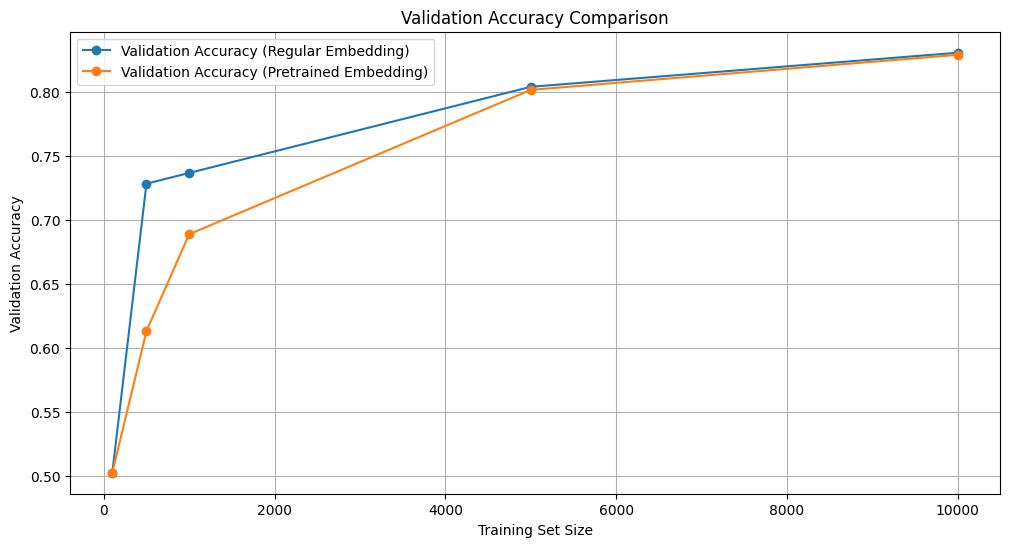

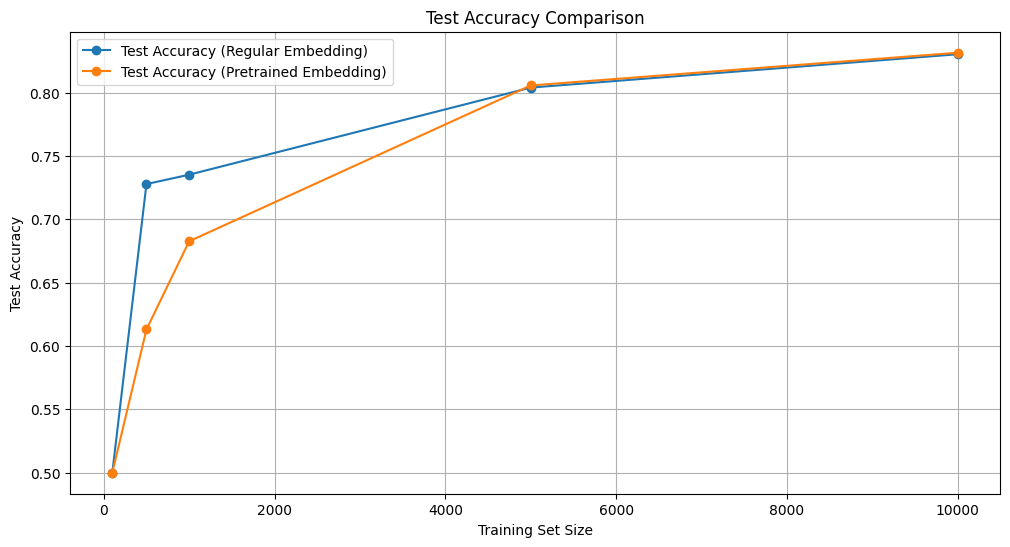

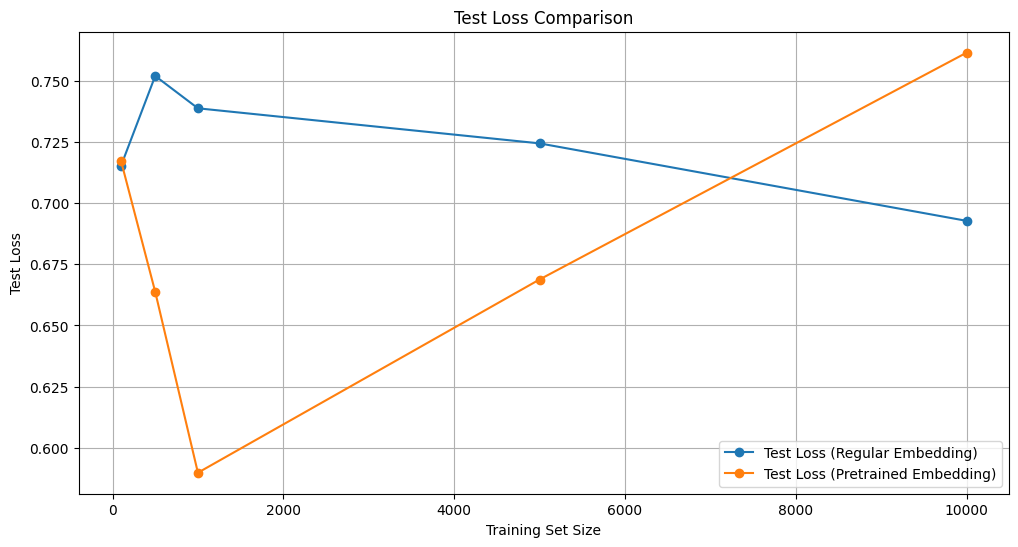

In [13]:
# Visualizations
# Validation accuracy comparison
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, validation_results_regular, marker='o', label='Validation Accuracy (Regular Embedding)')
plt.plot(train_sizes, validation_results_pretrained, marker='o', label='Validation Accuracy (Pretrained Embedding)')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Training Set Size")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

# Test accuracy comparison
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, test_results_regular, marker='o', label='Test Accuracy (Regular Embedding)')
plt.plot(train_sizes, test_results_pretrained, marker='o', label='Test Accuracy (Pretrained Embedding)')
plt.title("Test Accuracy Comparison")
plt.xlabel("Training Set Size")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid()
plt.show()

# Test loss comparison
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, test_loss_regular, marker='o', label='Test Loss (Regular Embedding)')
plt.plot(train_sizes, test_loss_pretrained, marker='o', label='Test Loss (Pretrained Embedding)')
plt.title("Test Loss Comparison")
plt.xlabel("Training Set Size")
plt.ylabel("Test Loss")
plt.legend()
plt.grid()
plt.show()


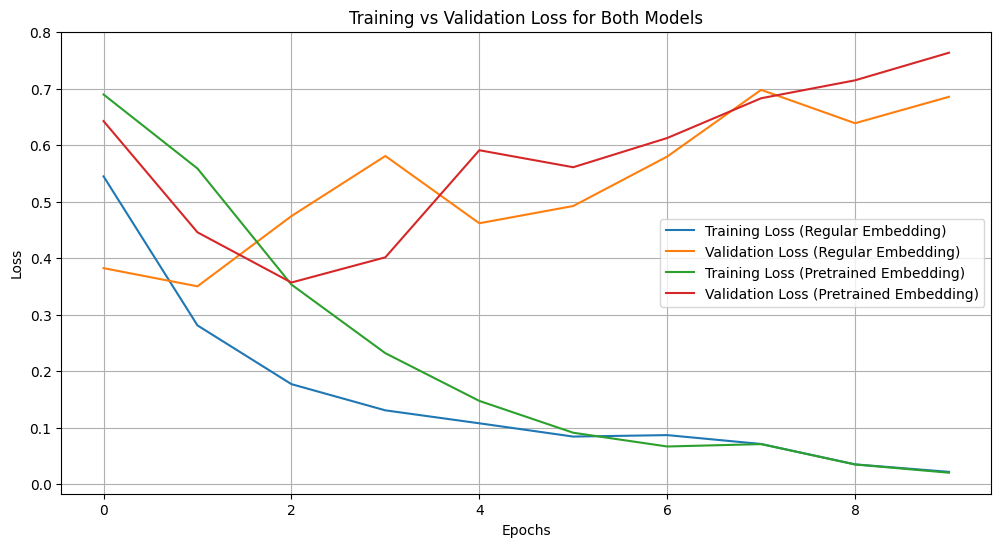

In [15]:
# Visualize training vs validation loss for both models
plt.figure(figsize=(12, 6))

# Regular Embedding Model
plt.plot(history_regular.history['loss'], label='Training Loss (Regular Embedding)')
plt.plot(history_regular.history['val_loss'], label='Validation Loss (Regular Embedding)')

# Pretrained Embedding Model
plt.plot(history_pretrained.history['loss'], label='Training Loss (Pretrained Embedding)')
plt.plot(history_pretrained.history['val_loss'], label='Validation Loss (Pretrained Embedding)')

plt.title("Training vs Validation Loss for Both Models")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


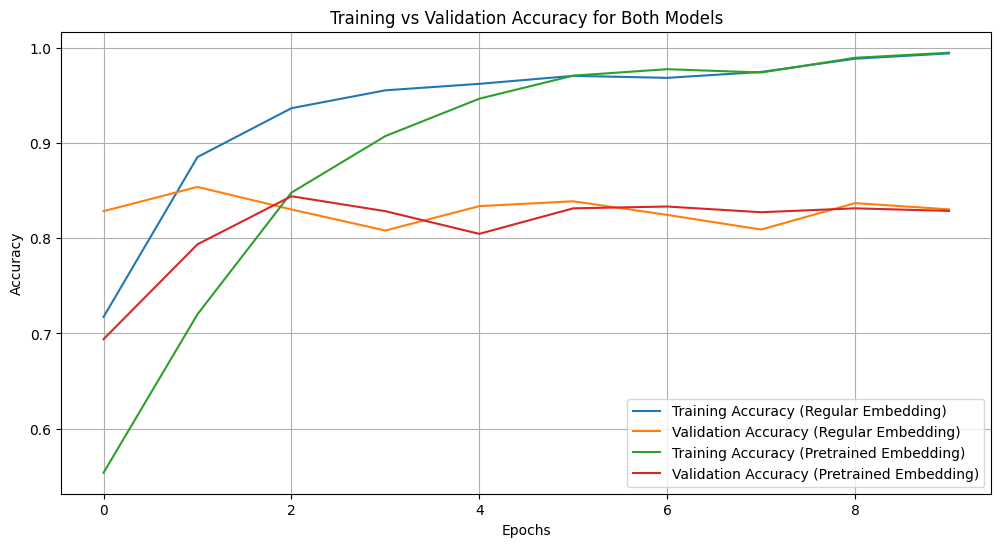

In [16]:
# Visualize training vs validation accuracy for both models
plt.figure(figsize=(12, 6))

# Regular Embedding Model
plt.plot(history_regular.history['accuracy'], label='Training Accuracy (Regular Embedding)')
plt.plot(history_regular.history['val_accuracy'], label='Validation Accuracy (Regular Embedding)')

# Pretrained Embedding Model
plt.plot(history_pretrained.history['accuracy'], label='Training Accuracy (Pretrained Embedding)')
plt.plot(history_pretrained.history['val_accuracy'], label='Validation Accuracy (Pretrained Embedding)')

plt.title("Training vs Validation Accuracy for Both Models")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


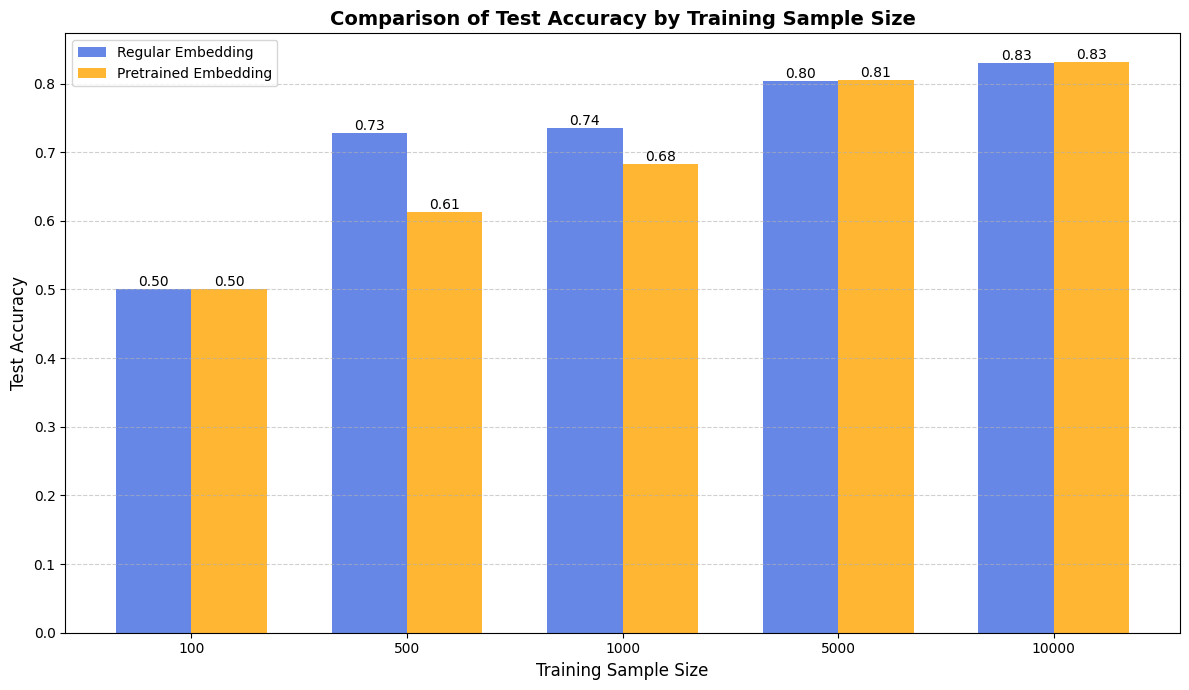

In [17]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(train_sizes))
width = 0.35  # Width of the bars

plt.figure(figsize=(12, 7))
bars_regular = plt.bar(x - width/2, test_results_regular, width, label='Regular Embedding', color='royalblue', alpha=0.8)
bars_pretrained = plt.bar(x + width/2, test_results_pretrained, width, label='Pretrained Embedding', color='orange', alpha=0.8)

for bar in bars_regular:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',
             ha='center', va='bottom', fontsize=10, color='black')
for bar in bars_pretrained:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',
             ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Training Sample Size', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Comparison of Test Accuracy by Training Sample Size', fontsize=14, fontweight='bold')
plt.xticks(x, train_sizes, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10, loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


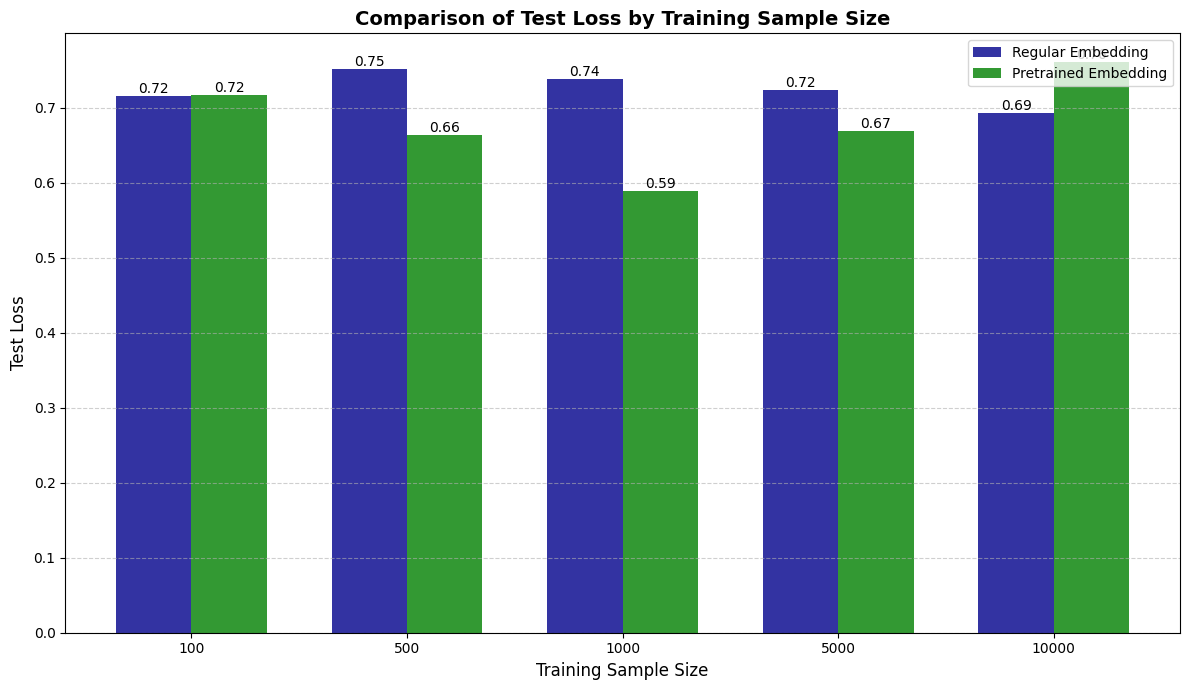

In [18]:
# bar graph for test loss comparison with numbers
plt.figure(figsize=(12, 7))
bars_regular = plt.bar(x - width/2, test_loss_regular, width, label='Regular Embedding', color='darkblue', alpha=0.8)
bars_pretrained = plt.bar(x + width/2, test_loss_pretrained, width, label='Pretrained Embedding', color='green', alpha=0.8)


for bar in bars_regular:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',
             ha='center', va='bottom', fontsize=10, color='black')
for bar in bars_pretrained:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',
             ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Training Sample Size', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.title('Comparison of Test Loss by Training Sample Size', fontsize=14, fontweight='bold')
plt.xticks(x, train_sizes, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()
